# Prostate Cancer (modelling lpsa levels)

Prostate specific antigen is useful as a preoperative marker for patients with prostate cancer [Stamey].
We will use the dataset from [Hastie] (and [Stamey]) to model the dependence of the logarithm of prostate specific antigen (lpsa) on the given (8) predictors.
We will use multilinear regression, and will choose what predictors to keep using backwards stepwise selection.
One of the goals of this project is to make sure we understand all the concepts involved in the data analysis, and thus role Z-scores and p-values in the backwards selection section will be discussed in some detail.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as skmetrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
%matplotlib inline

In [44]:
pd.__version__ #Made with pandas 0.25.1

'0.25.1'

## A first look at the data

In [45]:
df_original = pd.read_table('http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/prostate.data')

In [46]:
print('columns: {}'.format(df_original.columns.to_list()))
df_original.head()

columns: ['Unnamed: 0', 'lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45', 'lpsa', 'train']


,Unnamed: 0,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


The unnamed column is useless, so we'll delete it.
We will also delete the 'train' column, since it just lets us know what rows were used as part of the training set in the original analysis in [Hastie].

In [47]:
df = df_original.copy(deep=True)
df = df.drop(columns=['Unnamed: 0','train'])
df.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


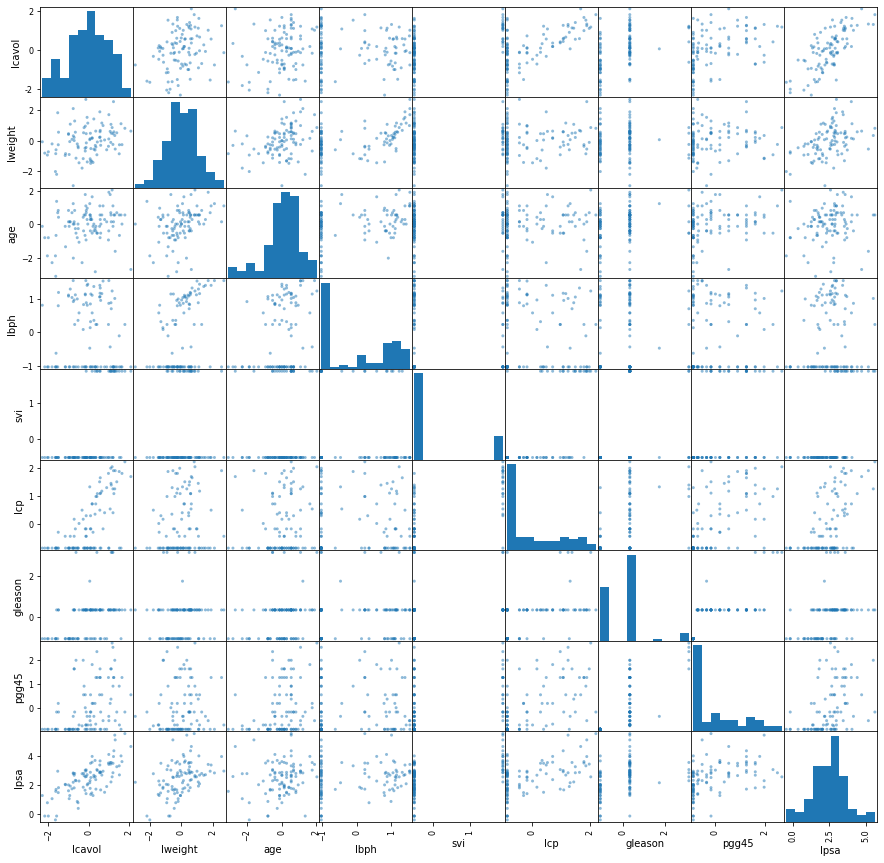

In [70]:
pd.plotting.scatter_matrix(df, figsize=(15,15))
#plt.savefig('images/scatter_prostate.png')
plt.show()

Notice that there are two categorical/discrete predictors/features, namely svi and gleason.  
Also, it is immediately clear that there is a strong linear relationship between the response (independent variable) lpsa and the predictors lcavol, lweight, svi and lcp.   
The predictors lcavol and lcp seem to be strongly related as well, so maybe we will need only one of them.
We will explore this later.

In [49]:
corr = df.corr()
corr.style.background_gradient()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
lcavol,1,0.280521,0.225,0.0273497,0.538845,0.67531,0.432417,0.433652,0.73446
lweight,0.280521,1,0.347969,0.442264,0.155385,0.164537,0.0568821,0.107354,0.433319
age,0.225,0.347969,1,0.350186,0.117658,0.127668,0.268892,0.276112,0.169593
lbph,0.0273497,0.442264,0.350186,1,-0.0858432,-0.00699943,0.0778204,0.07846,0.179809
svi,0.538845,0.155385,0.117658,-0.0858432,1,0.673111,0.320412,0.457648,0.566218
lcp,0.67531,0.164537,0.127668,-0.00699943,0.673111,1,0.51483,0.631528,0.548813
gleason,0.432417,0.0568821,0.268892,0.0778204,0.320412,0.51483,1,0.751905,0.368987
pgg45,0.433652,0.107354,0.276112,0.07846,0.457648,0.631528,0.751905,1,0.422316
lpsa,0.73446,0.433319,0.169593,0.179809,0.566218,0.548813,0.368987,0.422316,1


Looking at the lpsa column or row, one sees that the correlations agree what our expectations, except perhaps in the case of pgg45, which is more strongly correlated with the response lpsa than expected.
This gives us an idea of what to expect in terms of the dependence of lpsa on the predictors, but we'll conduct the analysis in a controlled manner using Z-scores later in this project.

## Standardization of the variables

We now standardize the predictors, so that we will end up with $\mu = 0$ and $\sigma = 1$ for every variable (up to computational errors).

In [50]:
#Means and standard deviations before standardization.
df.describe().loc[['mean', 'std']]

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329


In [51]:
scaler = StandardScaler()
#If we simply applied the scaler to our dataframe df we would lose the column labels.
#So instead we loop over the columns:
iterator = pd.DataFrame(df.iloc[:,:-1]).items() #Will not change the response, only the predictors.
for column,_ in iterator:
    column_data = pd.DataFrame(df[column]) #Create dataframe with a single column.
    new_column_array = scaler.fit_transform(column_data) #The scaler transforms the column.
    df[column] = pd.DataFrame(new_column_array) #Update column.
#Means and standard deviations after standardization.
df.describe().loc[['mean', 'std']]

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
mean,-9.614302e-17,-3.216213e-16,3.433679e-16,-4.721309e-17,-1.327689e-16,8.240831e-17,-1.476482e-16,-1.816989e-16,2.478387
std,1.005195e+00,1.005195e+00,1.005195e+00,1.005195e+00,1.005195e+00,1.005195e+00,1.005195e+00,1.005195e+00,1.154329


## A first model

Let's build a first linear model with all the predictors.

We will split the data using the mask from the original table.

In [10]:
mask_origin = df_original['train']
mask_origin.tail()

92    T
93    T
94    F
95    T
96    F
Name: train, dtype: object

In [11]:
mask = mask_origin == 'T'
mask.tail()

92     True
93     True
94    False
95     True
96    False
Name: train, dtype: bool

In [12]:
df[mask].tail()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
90,1.617422,1.109520,0.558151,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957,4.029806
91,1.008835,0.114086,-0.386947,0.864484,1.902379,-0.867655,0.344407,-0.334356,4.129551
92,1.262444,0.580608,0.558151,-1.030029,1.902379,1.079149,0.344407,1.269449,4.385147
93,2.107397,0.628738,-2.682185,-1.030029,1.902379,1.688267,0.344407,0.556647,4.684443
95,1.307045,0.340141,0.558151,1.010033,1.902379,1.249088,0.344407,1.982251,5.477509


In [13]:
train_df_from_source = df[mask]
test_df_from_source = df[~mask]

One can at last build the model (using least-squares estimation).
The LinearRegression class from sklearn does just that:

In [14]:
print(LinearRegression.__doc__[1:45])

    Ordinary least squares Linear Regression


In [15]:
X_train = train_df_from_source.iloc[:,0:-1] #The last column contains the response lpsa.
y_train = train_df_from_source.iloc[:,-1]
regression = LinearRegression().fit(X = X_train, y = y_train)
print(' intercept: {} \n coeficients: '.format(regression.intercept_))
coefs_df = pd.DataFrame(data=np.array([regression.coef_]), columns=X_train.columns, index=['coeficients'])
coefs_df

 intercept: 2.464932922123745 
 coeficients: 


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
coeficients,0.676016,0.261694,-0.140734,0.209061,0.303623,-0.287002,-0.021195,0.265576


We can also fit the data using the `statsmodels` module, which immediately gives us a bit more information - and in particular the F-statistics - but is less pleasant to use than `sklearn`.

In [16]:
X_train_sm = sm.add_constant(X_train, prepend=True)
model = sm.OLS(y_train, X_train_sm)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   lpsa   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     16.47
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           2.04e-12
Time:                        15:35:52   Log-Likelihood:                -67.505
No. Observations:                  67   AIC:                             153.0
Df Residuals:                      58   BIC:                             172.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4649      0.089     27.598      0.0

/home/simoes/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Notice that the value of the F-statistic is large (and the corresponding p-value is very small), and we can thus safely reject the null hypothesis *i.e.* we can conclude that at least one of our predictors is significant.  
The t-scores above (which we will call Z-scores below, following the literature) will be used to decide what predictors we can drop. More on this below.

## Confidence intervals

I'll define my own function for estimating the variance of the coefficients according to the theory in [Hastie].

In [17]:
def coef_variance_estimate(X_train, y_true, y_pred):
    '''
    Estimates the variance of the coeficients of the model.
    The data is encoded in X_train and y_true:
        X_train is a (numpy) array (N, p + 1), where p is the number of predictors.
        y_true is a vector of length N.
    y_pred ia vector of length N, and is the prediction of the model on X.
    '''
    N = len(y_true)
    p = X_train.shape[1] - 1
    variance_y_est = (1/(N-p-1)) * np.sum(np.square(y_true - y_pred)) # Estimative of the variance of y.
    diag = np.diag(np.linalg.inv(np.matmul(np.transpose(X_train),X_train))) # Diagonal of (X^t X)^{-1}.
    return variance_y_est * diag

In [18]:
#Define these again for practicality
X_train = train_df_from_source.iloc[:,0:-1] #The last column contains the response lpsa.
y_train = train_df_from_source.iloc[:,-1]
y_pred = regression.predict(X_train)

#prepare X
column_of_ones = np.ones((X_train.shape[0],1))
X = np.concatenate([column_of_ones, X_train], axis = 1)

#Standard deviations
columns = ['Intercept'] + X_train.columns.to_list()
std_devs = np.sqrt(np.array([coef_variance_estimate(X, y_train.to_numpy(), y_pred)]))
std_devs_df = pd.DataFrame(data=std_devs, columns=columns, index=['coefficient std_dev'] )
std_devs_df

,Intercept,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
coefficient std_dev,0.089315,0.125975,0.095134,0.100819,0.101691,0.122962,0.153731,0.144497,0.15282


The $95\%$ confidence intervals are simply given by $\beta_i \pm 2\sigma_{\beta_i}$.

## Z-scores

I'll define my own Z-score function according to the theory in [Hastie].

In [19]:
#We could use the function coefcoef_variance_estimate above when defining the Z_score, but we won't so that this function stands by itself and can be easily copied.
def Z_score(X_train, y_true, y_pred, beta_hat):
    '''
    Returns the Z-scores of the model with coefficients beta_hat.
    The data is encoded in X_train and y_true:
        X_train is a (numpy) array (N, p + 1), where p is the number of predictors.
        y_true is a vector of length N.
    y_pred ia vector of length N, and is the prediction of the model on X.
    '''
    N = len(y_true)
    p = X_train.shape[1] - 1
    variance_y_est = (1/(N-p-1)) * np.sum(np.square(y_true - y_pred)) # Estimative of the variance of y.
    diag = np.diag(np.linalg.inv(np.matmul(np.transpose(X_train),X_train))) # Diagonal of (X^t X)^{-1}.
    Z = (1/np.sqrt(variance_y_est)) * np.multiply(beta_hat, np.sqrt(1/diag))
    return Z

In [20]:
#Define these again for practicality
X_train = train_df_from_source.iloc[:,0:-1] #The last column contains the response lpsa.
y_train = train_df_from_source.iloc[:,-1]
y_pred = regression.predict(X_train)

#prepare beta
beta_hat = regression.coef_
beta_hat = np.concatenate([np.array([regression.intercept_]), beta_hat])

#prepare X
column_of_ones = np.ones((X_train.shape[0],1))
X = np.concatenate([column_of_ones, X_train], axis = 1)

#Z-scores 
columns = ['Intercept'] + X_train.columns.to_list()
Zscores = np.array([Z_score(X, y_train.to_numpy(), y_pred, beta_hat)])
Zscores_df = pd.DataFrame(data=Zscores, columns=columns, index=['Z-score'] )
Zscores_df

,Intercept,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
Z-score,27.598203,5.36629,2.750789,-1.395909,2.055846,2.469255,-1.866913,-0.146681,1.73784


## Visualization

Let's see how the linear dependence looks like in the variable with the highest |Z-score|.
For that we set all other predictors to zero (and just write $x:=$lcavol).

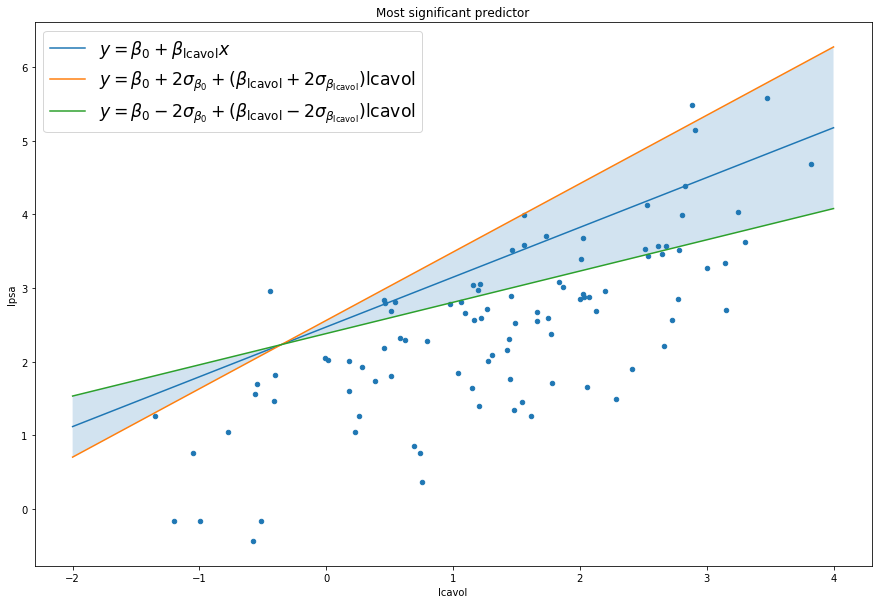

In [71]:
df_original.plot(x='lcavol', y='lpsa', kind='scatter', figsize=(15,10))
plt.title('Most significant predictor')
x = np.linspace(-2, 4)
slope = coefs_df['lcavol'].to_numpy()
intercept = regression.intercept_
y = intercept + slope*x
y_lower_bound = intercept-std_devs_df.loc['coefficient std_dev', 'Intercept'] + (slope-2*std_devs_df.loc['coefficient std_dev', 'lcavol'])*x
y_upper_bound = intercept+std_devs_df.loc['coefficient std_dev', 'Intercept'] + (slope+2*std_devs_df.loc['coefficient std_dev', 'lcavol'])*x
plt.plot(x, y, label=r'$y=\beta_0 + \beta_{\mathrm{lcavol}}x$')
plt.plot(x, y_upper_bound, label=r'$y=\beta_0+2\sigma_{\beta_0} + (\beta_{\mathrm{lcavol}}+2\sigma_{\beta_{\mathrm{lcavol}}})\mathrm{lcavol}$')
plt.plot(x, y_lower_bound, label=r'$y=\beta_0-2\sigma_{\beta_0} + (\beta_{\mathrm{lcavol}}-2\sigma_{\beta_{\mathrm{lcavol}}})\mathrm{lcavol}$')
plt.fill_between(x, y_lower_bound, y_upper_bound, alpha=0.2)
plt.legend(fontsize='xx-large')
#plt.savefig('images/lcavol_prostate.png')
plt.show()

The slope looks good.
The intercept doesn't, but that's hardly a surprise: the line goes up and down according to the value of the other predictors, so since we simply arbitrarily set all of them to zero we couldn't expect to obtain a good univariate linear regression w.r.t. lcavol.  
This means that the only thing we can analyze in this graph is the slope. 

## Selecting the significant predictors

We will keep variables with a p-value smaller than $5\%$ *i.e.* we reject the null hypothesis for variables whose t-score (or Z-score) has an unlikely value ($5\%$ probability) under the null hypothesis. 
Under the null hypothesis, the Z-scores follow a t-student distribution with $n-p-1$ degrees of freedom, where $n$ is the number of samples and $p$ is the number of predictors.
So in this case they follow the distribution $t_{67-9}$.  
Since the $t$-student pdf is symmetric, we can now simply find a critical (positive) value for $t$ for which the survival value is $2.5\%$ and then exclude variables with $\vert t \vert <$`t_critical`.

In [41]:
#Use the inverse survival function of the t-statistics function to get the value t_critical for which the probability of having t>t_critical is 0.025.
t_critical = stats.t.isf(0.025, 67-9) 
print('t_critical: {}, critical survival value: {}'.format(t_critical, stats.t.sf(t_critical, 67-9)))

t_critical: 2.0017174830120927, critical survival value: 0.025000000062729812


Let's visualize what we are doing.

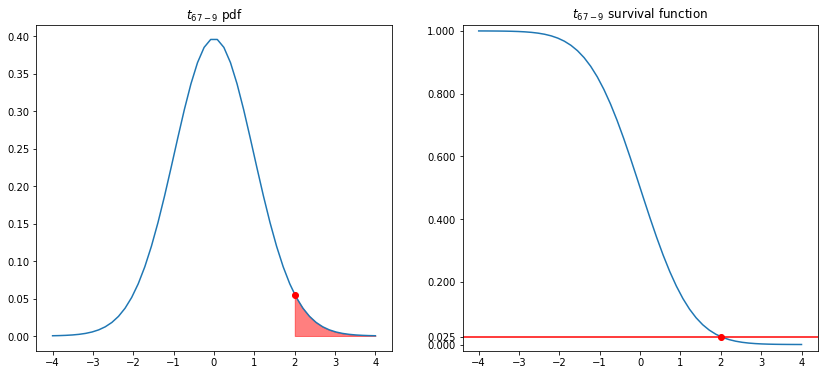

In [72]:
xs = np.linspace(-4, 4)
plt.figure(figsize=(14,6)) 

#First we plot the pdf of the t distribution.
plt.subplot(1, 2, 1); plt.gca().set_title('$t_{67-9}$ pdf')
ys = stats.t.pdf(xs, df=67-9)
plt.plot(xs, ys); plt.plot(t_critical, stats.t.pdf(t_critical, 67-9), 'ro')
#Add fill
tail = np.linspace(t_critical, 4)
plt.fill_between(tail, stats.t.pdf(tail, 67-9), color='r', alpha=0.5)

#Second, we plot the survival function.
plt.subplot(1, 2, 2)
ys = stats.t.sf(xs, df=67-9)
plt.gca().set_title('$t_{67-9}$ survival function')
plt.plot(xs, ys); plt.plot(t_critical, stats.t.sf(t_critical, 67-9), 'ro')
plt.yticks(list(plt.yticks()[0]) + [stats.t.sf(t_critical, 67-9)])
plt.gca().set_ylim([-0.02, 1.02])
#Add horizontal line
plt.axhline(y=stats.t.sf(t_critical, 67-9), color='r')
#plt.savefig('images/tdist_prostate.png')
plt.show()

Since `t_critical` $\approx 2$, we will eliminate predictors until all the surviving predictors have |Z-value| higher than $2$.

One first approach to accomplish this would be to simply eliminate at once all the predictors with a Z-value lower than $2$.  
Instead, we will adopt a finer method: we'll use stepwise backward selection with threshold $5\%$, meaning that we eliminate the predictor with highest p-value (lowest |Z-score|), then re-fit the model, and repeat until all predictors have p-values below the threshold $5\%$ (|Z-value| above $2$). 

In [24]:
def find_worst_predictor(df):
    '''
    df is a Dataframe with the response in the last column, and the predictors in the other columns.
    This function makes a linear fit of the data and computes the Z-values.
    Outputs a tuple: the column name (of the dataframe df) of the worst predictor, and its |Z-score|.
    '''
    X_train = df.iloc[:,0:-1] #The last column contains the response.
    y_train = df.iloc[:,-1]
    #Fit the linear model
    regression = LinearRegression().fit(X=X_train, y=y_train)
    #Prepare the data to feed into the Z_score function
    y_pred = regression.predict(X_train)
    beta_hat = regression.coef_
    beta_hat = np.concatenate([np.array([regression.intercept_]), beta_hat])
    #prepare X
    column_of_ones = np.ones((X_train.shape[0],1))
    X = np.concatenate([column_of_ones, X_train], axis = 1)
    #Z-scores 
    columns = ['Intercept'] + X_train.columns.to_list()
    Zscores = np.array([Z_score(X, y_train.to_numpy(), y_pred, beta_hat)])
    Zscores_df = pd.DataFrame(data=Zscores, columns=columns, index=['Z-score'] )
    #Extract worst_predictor with highest Zscore, and its Zscore.
    Zscores_no_intercept =  Zscores_df.drop(columns=['Intercept']) #We only want to analyze the predictors, so we drop the intercept.
    worst_predictor = Zscores_no_intercept.abs().idxmin(axis=1)[0] #Find column with lowest |Zscore|.
    score = Zscores_df.loc['Z-score', worst_predictor]
    return worst_predictor, np.abs(score)

Let's test this:

In [25]:
find_worst_predictor(train_df_from_source)

('gleason', 0.1466812064437132)

We get the already known result! Now let's use this function to implement backwards selection.

In [26]:
def backwards_selection(df, critical_p):
    '''
    Implements backwards selection on df with threshold critical_p for the p-values.
    Returns a tuple:
        dataframe without unsignificant predictors;
        A log with the record of what variables we dropped, and their scores.
    '''
    #Initialize log
    log = pd.DataFrame(data={}, columns = ['worst predictor', 'Z score', 'p-value'])
    #Compute max_p.
    worst_predictor, Zscore = find_worst_predictor(df) #Smallest Zscore
    dof = len(df.index) - (len(df.columns)-1) - 1 #Degrees of freedom of the t-student distribution = n-p-1
    max_p = 2*stats.t.sf(Zscore, dof) #Highest p-value
    while max_p > critical_p:
        #Update log
        log = log.append({'worst predictor': worst_predictor, 'Z score': Zscore, 'p-value': max_p}, ignore_index=True)
        #Eliminate non-significant predictor.
        df = df.drop(columns=[worst_predictor])
        #Update max_p
        worst_predictor, Zscore = find_worst_predictor(df) #Smallest Zscore
        dof = len(df.index) - (len(df.columns)-1) - 1 #Degrees of freedom of the t-student distribution = n-p-1
        max_p = 2*stats.t.sf(Zscore, dof) #Highest p-value
    return (df, log)

Let's see what variables are dropped when we use the backwards selection with `critical_p`$=5\%$.

In [27]:
backwards_selection(train_df_from_source, 0.05)[1]

,worst predictor,Z score,p-value
0,gleason,0.146681,0.883892
1,age,1.486490,0.142474
2,lcp,1.733570,0.088131
3,pgg45,1.190849,0.238326
4,lbph,1.988469,0.051179
5,svi,1.985388,0.051458


We drop 6 of our 8 predictors!
Notice that the last two predictors had p-values that were very close to $5\%$. So we can consider keeping them after all by simply moving the threshold to $6\%$.  

In [28]:
backwards_selection(train_df_from_source, 0.06)[1]

,worst predictor,Z score,p-value
0,gleason,0.146681,0.883892
1,age,1.486490,0.142474
2,lcp,1.733570,0.088131
3,pgg45,1.190849,0.238326


To decide whether we drop them or not, we can use the model error to see if dropping them hurts the performance of the model.

## Error 

We will compare the errors (MSE on the test set) of four models: the model with all predictors, the base model, the model after a $5\%$ backwards selection and the model after a $6\%$ backwards selection.

### MSE of the model with all predictors

In [74]:
#Train the model again, for completeness.
X_train = train_df_from_source.iloc[:,0:-1] #The last column contains the response lpsa.
y_train = train_df_from_source.iloc[:,-1]
regression = LinearRegression().fit(X = X_train, y = y_train)
#Retrieve the test sets.
X_test = test_df_from_source.iloc[:,0:-1] #The last column contains the response lpsa.
y_test = test_df_from_source.iloc[:,-1]
y_pred = regression.predict(X_test)

reg_error_all = skmetrics.mean_squared_error(y_test, y_pred)
print('regression (with all variables) MSE: {}'.format(reg_error_all))

regression (with all variables) MSE: 0.5212740055076004


### The base MSE

Let's compare this with the base error rate (*i.e.* the MSE of the base model which simply takes the average as the predicted values).

In [63]:
y_pred = np.ones(y_test.shape) * df['lpsa'].mean()
base_error = skmetrics.mean_squared_error(y_test, y_pred)
print('base MSE: {}; regression (with all variables) MSE: {}; improvement percentage: {}'.format(base_error, reg_error_all, (base_error-reg_error_all)/base_error))

base MSE: 1.0530258714099834; regression (with all variables) MSE: 0.5212740055076004; improvement percentage: 0.5049751201177769


It's a good sign that our linear model reduces the base error rate by approximately $50.5\%$.

### MSE of the model after backwards selection with threshold $5\%$.

In [73]:
#Drop predictors
train_df_after_5backwards, log = backwards_selection(train_df_from_source, 0.05)
dropped_predictors = log['worst predictor'].to_list()
#Train the model
X_train = train_df_after_5backwards.iloc[:,0:-1] #The last column contains the response lpsa.
y_train = train_df_after_5backwards.iloc[:,-1]
regression = LinearRegression().fit(X = X_train, y = y_train)
#Retrieve the test sets.
X_test = test_df_from_source.iloc[:,0:-1] #The last column contains the response lpsa.
X_test = X_test.drop(columns=dropped_predictors)
y_test = test_df_from_source.iloc[:,-1]
y_pred = regression.predict(X_test)

reg_error_5 = skmetrics.mean_squared_error(y_test, y_pred)
print('base MSE: {}; regression (with 5% backwards selection) MSE: {}; improvement percentage: {}'.format(base_error, reg_error_5, (base_error-reg_error_5)/base_error))

base MSE: 1.0530258714099834; regression (with 5% backwards selection) MSE: 0.4924823476805037; improvement percentage: 0.532316953408677


Which is even lower than the MSE of the model before the cutoff! (Notice that this MSE is *on the test set*).  
We see that this improves the base model by approximately $53.2\%$.

### MSE of the model after backwards selection with threshold $6\%$.

In [75]:
#Drop predictors
train_df_after_5backwards, log = backwards_selection(train_df_from_source, 0.06)
dropped_predictors = log['worst predictor'].to_list()
#Train the model
X_train = train_df_after_5backwards.iloc[:,0:-1] #The last column contains the response lpsa.
y_train = train_df_after_5backwards.iloc[:,-1]
regression = LinearRegression().fit(X = X_train, y = y_train)
#Retrieve the test sets.
X_test = test_df_from_source.iloc[:,0:-1] #The last column contains the response lpsa.
X_test = X_test.drop(columns=dropped_predictors)
y_test = test_df_from_source.iloc[:,-1]
y_pred = regression.predict(X_test)

reg_error_6 = skmetrics.mean_squared_error(y_test, y_pred)
print('base MSE: {}; regression (with 6% backwards selection) MSE: {}; improvement percentage: {}'.format(base_error, reg_error_6, (base_error-reg_error_6)/base_error))

base MSE: 1.0530258714099834; regression (with 6% backwards selection) MSE: 0.4563321220401627; improvement percentage: 0.566646808564027


The improvement percentage is approximately $56.7\%$.  
This model gives us the best MSE, as suspected. So we keep it.

In [82]:
summary_table = pd.DataFrame({'Base': [base_error, 0], 'All predictors': [reg_error_all, (base_error-reg_error_all)/base_error],'5% backwards selection': [reg_error_5, (base_error-reg_error_5)/base_error], '6% backwards selection': [reg_error_6, (base_error-reg_error_6)/base_error]} , index=['MSE', 'Improvement w.r.t. base (%)'])
summary_table

,Base,All predictors,5% backwards selection,6% backwards selection
MSE,1.053026,0.521274,0.492482,0.456332
Improvement w.r.t. base (%),0.000000,0.504975,0.532317,0.566647


## Conclusion

The univariate plots suggest a linear relationship between many of the predictors and the response.  
Unsurprisingly, a multilinear model (using all the predictors) fits the data well, improving the base error (of the model which simply predicts the average) by $50.5\%$.  
However, some of the predictors turn out to be superfluous.
Using backwards selection with a threshold of $5\%$ on the p-value of the Z-scores actually improves our error on the test set: the base error is improves by $53.2\%$.  
Analyzing the Z-scores more carefully, one sees that it is actually better to cap the p-values at $6\%$ instead, and indeed the resulting model (which drops the predictors gleason, age, lcp and pgg45) behaves the best, with an improvement of $56.7\%$ w.r.t. the base error.

## References:
- [Hastie]: 'The Elements of Statistical Learning' by Trevor Hastie et al.
- [Gareth]: 'Introduction to Statistical Learning' by Gareth James et al.
- [Casella]: 'Statistical Inference' by George Casella and Roger Berger.
- [Downey]: 'Think stats' by Allen Downey.
- [Stamey]: Stamey, Thomas A., et al. "Prostate specific antigen in the diagnosis and treatment of adenocarcinoma of the prostate. II. Radical prostatectomy treated patients." The Journal of urology 141.5 (1989): 1076-1083.